In [680]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.formula.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from matplotlib.mlab import find
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 
plt.rcParams["figure.figsize"] = (20,5)

# Load cryogenic temperature data and plot

In [681]:
#load data
df = pd.read_csv('cryo_temp.csv',index_col=0)
s = pd.Series(df['Valor'])
s.index=pd.to_datetime(df.index)
s = s[s.values<0]

#resampling
rs = frame.resample('5min').pad().interpolate().dropna()

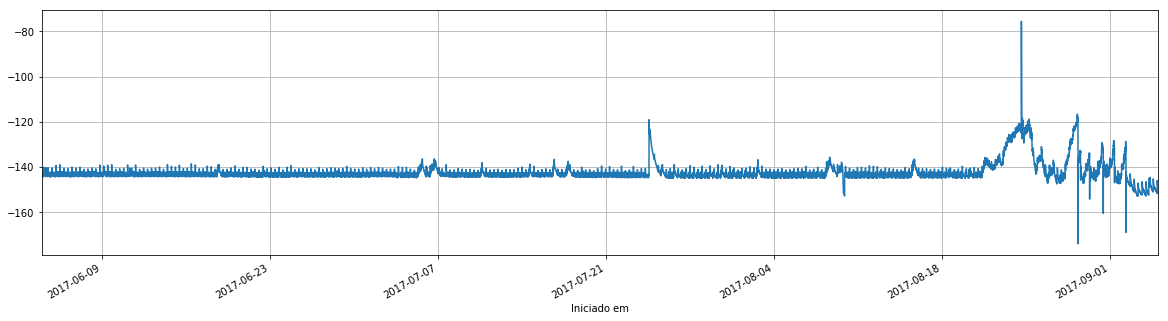

In [682]:
#plot all data
start = s.index.searchsorted(dt.datetime(2017, 6, 1))
end = s.index.searchsorted(dt.datetime(2017, 9, 11))
s.iloc[start:end].plot(grid=True)
#axes = plt.gca()
#axes.set_ylim([-200,-50])

# Analysing from 06/06/2017 to 11/06/2017

## Autocorrelation plot

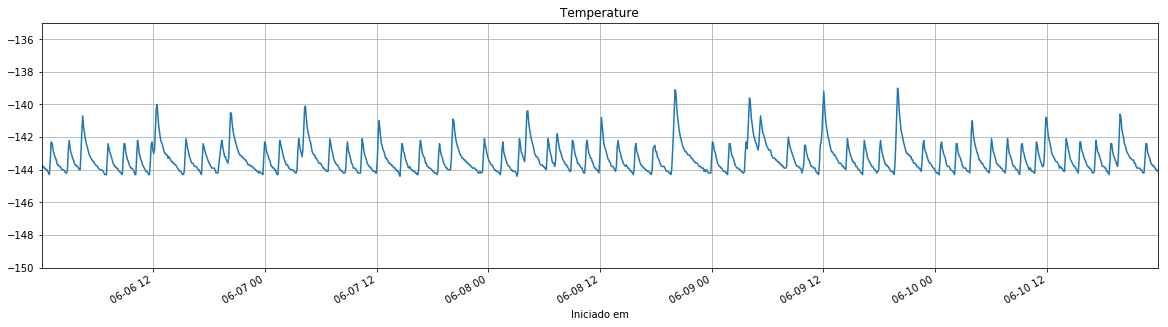

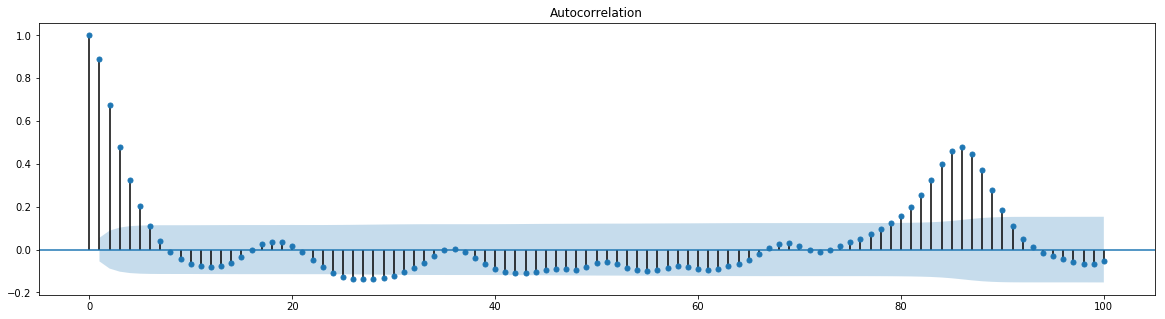

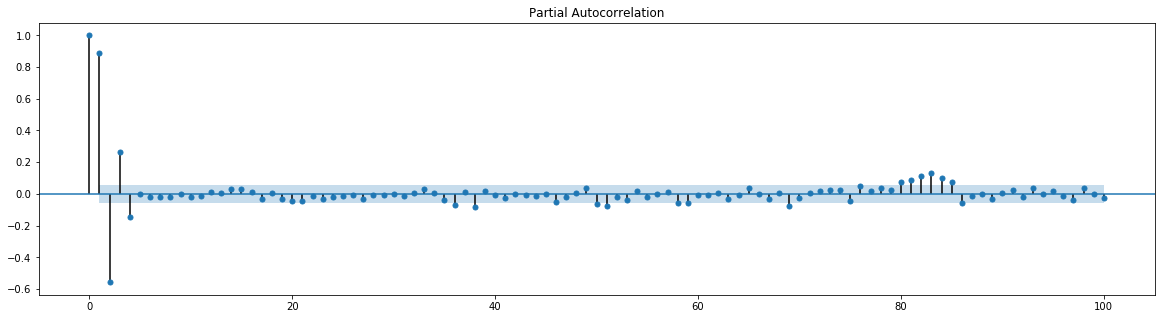

In [683]:
start = s.index.searchsorted(dt.datetime(2017, 6, 6))
end = s.index.searchsorted(dt.datetime(2017, 6, 11))
frame = s.iloc[start:end]
frame.plot(grid=True,title='Temperature')
axes = plt.gca()
axes.set_ylim([-150,-135])
fig2 = plot_acf(frame,lags=100)
fig3 = plot_pacf(frame,lags=100)

## Stationarity test

In [684]:
#Dickey-Fuller test
def test_stationarity(timeseries):

    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [637]:
# Test stationarity
test_stationarity(rs)

Results of Dickey-Fuller Test:
Test Statistic                -1.184818e+01
p-value                        7.314647e-22
#Lags Used                     3.000000e+00
Number of Observations Used    1.435000e+03
Critical Value (5%)           -2.863556e+00
Critical Value (1%)           -3.434915e+00
Critical Value (10%)          -2.567843e+00
dtype: float64


As the statistic test ranks lower than __1%__ threshold, we can assume with 99% confidence that this series __is stationary__. So now we can move foward to find a good ARIMA model.

## Semi-automatic ARIMA best orders

This section iterates over a set of AR, I and AM dimensions and evaluates the cost for each trial. The cost value is a sum of __AIC__ and __BIC__ evaluation criteria. The lower the better.

In [596]:
ar=range(5)
it=range(3)
am=range(5)

trials = pd.DataFrame()

for p in ar:
    for q in it:
        for d in am:
            try:
                model = ARIMA(rs, order=(p,q,d))
                model_fit = model.fit(disp=0)
                cost = model_fit.aic + model_fit.bic
                trials = trials.append(pd.DataFrame(np.array([[p,q,d,cost]]),columns=['p', 'q', 'd', 'cost']))
            except Exception as e:
                #Not all p,q,d combinations are feasible by the fit algorithm, so we bypass them 
                continue
                
trials.index=np.linspace(0,len(df)-1, num=len(df))
sorted_trials = trials.sort_values('cost')
best_model = tuple(sorted_trials.head(1).values[0][:-1].astype(np.int64))
print("Best model =", best_model)
display(sorted_trials)

,p,q,d,cost
22.0,2.0,0.0,1.0,1399.729716
24.0,2.0,0.0,3.0,1404.076291
36.0,4.0,0.0,0.0,1406.330911
13.0,1.0,0.0,2.0,1408.472685
14.0,1.0,0.0,3.0,1408.616551
23.0,2.0,0.0,2.0,1408.830606
32.0,3.0,0.0,1.0,1408.862165
37.0,4.0,0.0,1.0,1409.624570
31.0,3.0,0.0,0.0,1414.362252
27.0,2.0,1.0,2.0,1415.708699


## Fit ARIMA model

                              ARMA Model Results                              
Dep. Variable:                  Valor   No. Observations:                 1439
Model:                     ARMA(2, 1)   Log Likelihood                -338.343
Method:                       css-mle   S.D. of innovations              0.306
Date:                Sat, 14 Oct 2017   AIC                            686.686
Time:                        18:48:59   BIC                            713.044
Sample:                    06-06-2017   HQIC                           696.526
                         - 06-10-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -143.3131      0.064  -2232.803      0.000    -143.439    -143.187
ar.L1.Valor     1.1283      0.043     26.413      0.000       1.045       1.212
ar.L2.Valor    -0.2994      0.041     -7.309    

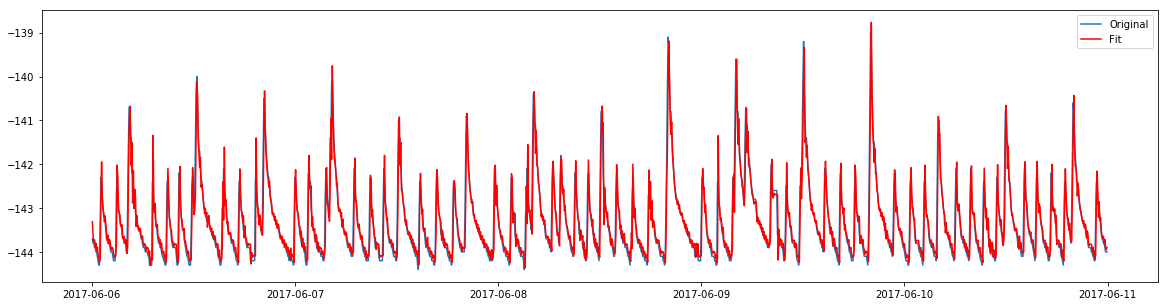

In [677]:
model = ARIMA(rs, order=best_model)
model_fit = model.fit(disp=0)
plt.plot(rs,label='Original')
plt.plot(model_fit.fittedvalues, color='red',label='Fit')
plt.legend()
print(model_fit.summary())

                 0
count  1439.000000
mean     -0.000047
std       0.306107
min      -1.243830
25%      -0.145726
50%      -0.058344
75%       0.046591
max       1.769878


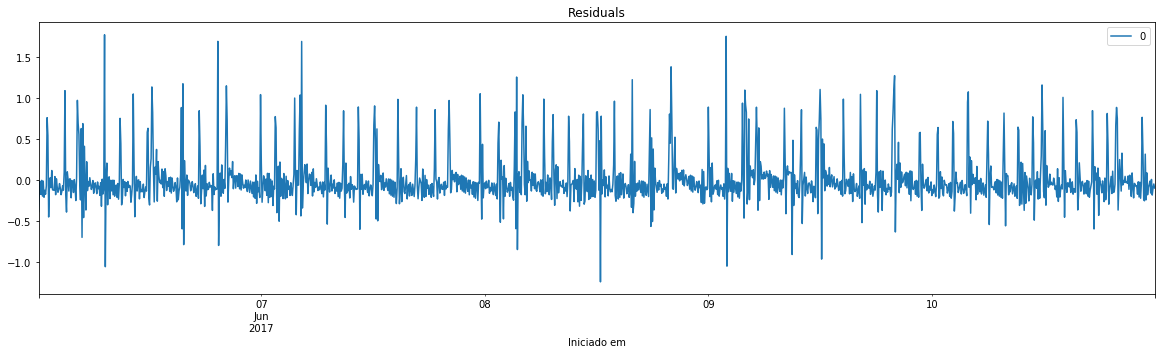

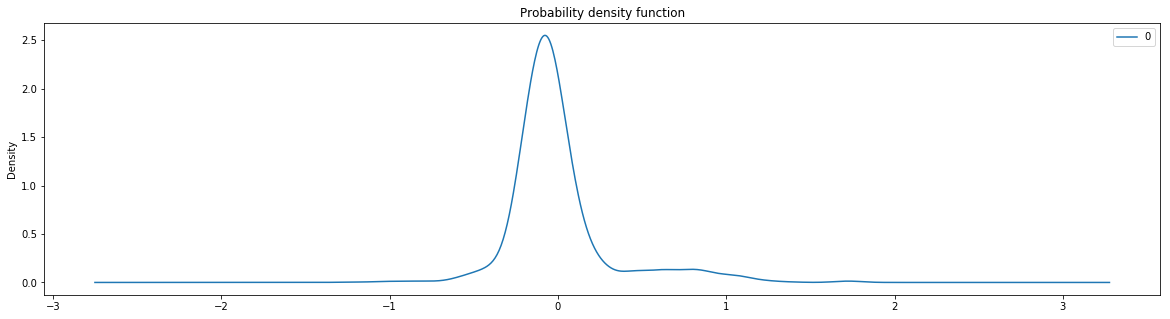

In [655]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
print(residuals.describe())
residuals.plot(title='Residuals')
fig2 = residuals.plot(kind='density',title='Probability density function')

## Prediction test

We will try to predict the last 200 samples by predicting a single next value each iteration. After predicting, we incorporate next real value from the dataset to train again.

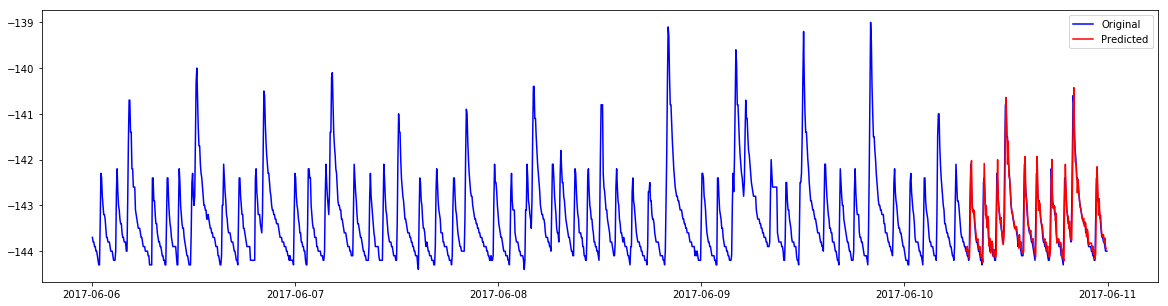

In [666]:
split = 200
train_set = rs[:-split]
predictions = pd.Series()

for i in range(split):
    
    model = ARIMA(train_set, order=best_model)
    model_fit = model.fit(disp=0)
    train_set = rs[:(-split+i)]
    
    forecasted_value = model_fit.forecast()[0]
    predicted = pd.Series(forecasted_value,index=train_set.tail(1).index)
    predictions = predictions.append(predicted)
    
    
plt.plot(rs.index,rs.values,'blue',label='Original')
plt.plot(predictions.index,predictions,'red',label='Predicted')
plt.legend()

In this section we try to predict the next value, but using the very same predicted value to incorporate in the training set each iteration.

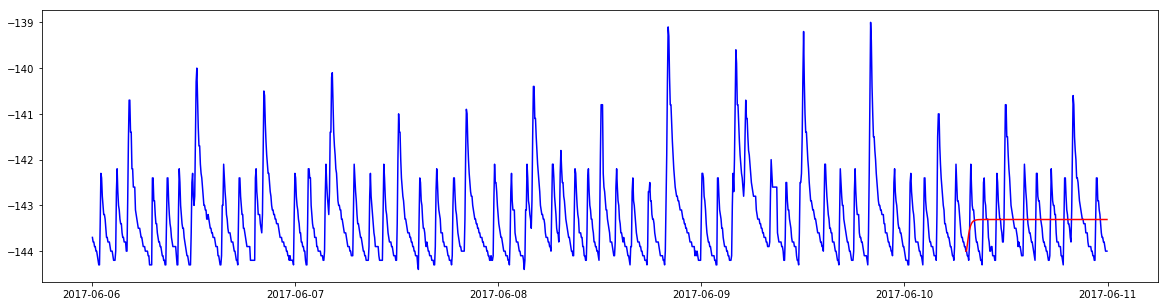

In [679]:
split = 200
train_set = rs[:-split]
predictions = train_set.tail(1)

for i in range(split):
    
    model = ARIMA(train_set, order=best_model)
    model_fit = model.fit(disp=0)
    forecasted_value = model_fit.forecast()[0]
    predicted = pd.Series(forecasted_value,index=predictions.tail(1).tshift(1).index)
    predictions = predictions.append(predicted).resample('5min').mean()
    train_set = train_set.append(predicted)
    
plt.plot(rs.index,rs.values,'blue',label='Original')
plt.plot(predictions.index,predictions,'red',label='Predicted')

This went very wrong quickly. What happend? 
<br><br>
Let's assume a single AR(1) process to simplify the math.

$ y_t = \mu + \gamma y_{t-1} + \epsilon_t$

Now, with $\gamma$ previously fit in early stages, and being less than 1, let's iterate to make preditions using the last predicted values. Error terms will be disconsidered.

$ \hat{y_t} = \mu + \gamma \hat{y_{t-1}}$

$ \hat{y_{t+1}} = \mu + \gamma \hat{y_{t}}$

$ \hat{y_{t+2}} = \mu + \gamma \hat{y_{t+1}}$

Combining $t+1$ and $t$ equations:

$ \hat{y_{t+1}} = \mu + \gamma (\mu + \gamma \hat{y_{t-1}})$

$ \hat{y_{t+1}} = \mu + \mu\gamma + \gamma^2 \hat{y_{t-1}}$

Now combining $t+1$ and $t+2$:

$ \hat{y_{t+2}} = \mu + \mu\gamma + \mu\gamma^2 +\gamma^3 \hat{y_{t-1}}$

$ \hat{y_{t+i}} = \mu + \mu\gamma + \mu\gamma^i +\gamma^{i+1} \hat{y_{t-1}}$

$ \hat{y_{t+i}} = \sum_{i=0}^{i} \mu\gamma^i + \gamma^{i+1}\hat{y_{t-1}}$

So from this we can conclude the more predicions are made, less the past values influence actual predicion. In fact, it tends to stabilise at some point around $\sum_{i=0}^{i} \mu\gamma^i$, since $\gamma$ is less than 1.
